### 🔹 1. Define Parameters and Spatial Grid


In [ ]:
# Importing required libraries
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
from scipy.integrate import solve_ivp  # For solving ODEs using time integration
a = 1.0
D = 1.0
nx = 101
xl, xu = -60, 20
xg = np.linspace(xl, xu, nx)
dx = xg[1] - xg[0]



**📝 Explanation:**

We define the spatial domain and model parameters:

- $a$ is a parameter in the reaction term of the PDE.
- $D$ is the diffusion coefficient.
- `nx = 101` sets the number of points on the spatial grid.
- `xl` and `xu` are the minimum and maximum values of $x$, respectively.
- `xg = np.linspace(xl, xu, nx)` creates a linearly spaced grid of $x$ values.
- $dx$ is the distance between consecutive grid points:  
  $$
  dx = xg[1] - xg[0]
  $$



### 🔹 2. Define time settings


In [ ]:
# Define time settings
t0 = 0
tf = 60
nout = 7
tout = np.linspace(t0, tf, nout)


**📝 Explanation:**

We define the time interval and output times:

- $t_0 = 0$ is the initial time.
- $t_f = 60$ is the final time.
- `nout = 7` is the number of time points at which we want to save the solution.
- `tout = np.linspace(t0, tf, nout)` generates a list of $7$ equally spaced time values between $t_0$ and $t_f$.


### 🔹  3. Boundary Condition Selector & Analytical Solution Functions

In [ ]:
# Boundary condition case selector (from 1 to 5)
ncase = 1  # You can change this value to test different boundary conditions

# Analytical solution function
def ua_1(x, t):
    return 1 / (1 + np.exp((x / np.sqrt(2 * D)) + (a - 0.5) * t))

# Analytical spatial derivative of the solution
def uxa_1(x, t):
    expa = np.exp((x / np.sqrt(2 * D)) + (a - 0.5) * t)
    return -expa / (np.sqrt(2 * D) * (1 + expa)**2)


**📝 Explanation:**

We select the boundary condition case and define the analytical solution:

- `ncase = 1`: Chooses which type of boundary condition to apply (1 to 5).  
  The options are:
  1. Analytical Dirichlet  
  2. Constant Dirichlet  
  3. Analytical Neumann  
  4. Homogeneous Neumann  
  5. No boundary condition

- The function $\texttt{ua\_1(x, t)}$ computes the analytical solution $u_a(x, t)$ at position $x$ and time $t$:
  $$
  u_a(x, t) = \frac{1}{1 + \exp\left( \frac{x}{\sqrt{2D}} + (a - 0.5)t \right)}
  $$

- The function $\texttt{uxa\_1(x, t)}$ computes the spatial derivative of the analytical solution:
  $$
  \frac{\partial u_a}{\partial x}(x, t) = -\frac{\exp\left( \frac{x}{\sqrt{2D}} + (a - 0.5)t \right)}{\sqrt{2D} \left(1 + \exp\left( \frac{x}{\sqrt{2D}} + (a - 0.5)t \right)\right)^2}
  $$

This derivative is useful for applying Neumann boundary conditions.


### 🔹  4. Define Initial Condition

In [ ]:
def initial_condition():
    return ua_1(xg, 0)


**📝 Explanation:**

We define the initial condition for the PDE simulation:

- The function `initial_condition()` returns the values of the analytical solution $u_a(x, t)$ at time $t = 0$.
- This ensures that the initial profile of $u(x, 0)$ exactly matches the known analytical solution:
  $$
  u(x, 0) = u_a(x, 0)
  $$


### 🔹  5. Finite Difference Scheme (4th-order)

In [ ]:
# 4th-order accurate finite difference method for second spatial derivative
def dss004(u, dx):
    uxx = np.zeros_like(u)

    # 4th-order central difference for interior points
    uxx[2:-2] = (-u[:-4] + 16*u[1:-3] - 30*u[2:-2] + 16*u[3:-1] - u[4:]) / (12*dx**2)

    # One-sided approximations for boundary points
    # Left boundary
    uxx[0] = (2*u[0] - 5*u[1] + 4*u[2] - u[3]) / dx**2
    uxx[1] = (u[0] - 2*u[1] + u[2]) / dx**2

    # Right boundary
    uxx[-1] = (2*u[-1] - 5*u[-2] + 4*u[-3] - u[-4]) / dx**2
    uxx[-2] = (u[-1] - 2*u[-2] + u[-3]) / dx**2

    return uxx


**📝 Explanation:**

This function `dss004(u, dx)` computes the second spatial derivative $\frac{\partial^2 u}{\partial x^2}$ using a **4th-order finite difference method**.

- For **interior points**, the central difference formula used is:
  $$
  u_{xx}(x_i) \approx \frac{-u_{i-2} + 16u_{i-1} - 30u_i + 16u_{i+1} - u_{i+2}}{12 \, dx^2}
  $$

- For **boundary points**, one-sided finite difference formulas are applied, since central differences can't be used at the edges.

- This high-order scheme improves accuracy while maintaining numerical stability.

This approximation is essential for solving PDEs like the FitzHugh–Nagumo equation which involve second-order spatial derivatives.


### 🔹  6. Define the PDE System (FitzHugh–Nagumo PDE)

In [ ]:
# Define the PDE system for the FitzHugh–Nagumo model
def fhn_pde(t, u):
    u = u.copy()
    dudt = np.zeros_like(u)

    # Apply boundary conditions
    if ncase == 1:  # Analytical Dirichlet
        u[0] = ua_1(xg[0], t)
        u[-1] = ua_1(xg[-1], t)
    elif ncase == 2:  # Constant Dirichlet
        u[0] = 1.0
        u[-1] = 0.0
    elif ncase == 3 or ncase == 4 or ncase == 5:
        pass  # Neumann and no BCs handled later

    # Compute second derivative
    uxx = dss004(u, dx)

    # Handle Neumann boundary conditions
    if ncase == 3:  # Analytical Neumann
        uxx[0] = uxa_1(xg[0], t)
        uxx[-1] = uxa_1(xg[-1], t)
    elif ncase == 4:  # Homogeneous Neumann
        uxx[0] = 0
        uxx[-1] = 0

    # Compute time derivative using PDE
    dudt = D * uxx - u * (1 - u) * (a - u)

    # Fix time derivative at boundaries for Dirichlet
    if ncase in [1, 2]:
        dudt[0] = 0
        dudt[-1] = 0

    return dudt


**📝 Explanation:**

This function `fhn_pde(t, u)` defines the time derivative $\frac{du}{dt}$ based on the FitzHugh–Nagumo PDE model.

It performs the following steps:

1. **Boundary Conditions**:
   - `ncase = 1`: Uses the exact analytical boundary values at both ends.
   - `ncase = 2`: Applies constant Dirichlet conditions ($u = 1$ on the left, $u = 0$ on the right).
   - `ncase = 3`: Will apply analytical Neumann boundary conditions (handled in the derivative).
   - `ncase = 4`: Homogeneous Neumann condition ($\frac{\partial u}{\partial x} = 0$ at both ends).
   - `ncase = 5`: No boundary condition is enforced.

2. **Second Derivative**:
   - Uses the `dss004` method to compute $\frac{\partial^2 u}{\partial x^2}$.

3. **Neumann BCs (if applicable)**:
   - Directly modifies the computed second derivative at boundaries for analytical or homogeneous Neumann cases.

4. **PDE Computation**:
   - The FitzHugh–Nagumo model has the form:
     $$
     \frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} - u(1 - u)(a - u)
     $$

5. **Enforcing Dirichlet Boundary Derivative**:
   - Sets time derivative to zero at the boundaries if Dirichlet conditions are applied.

This function will be passed to the ODE solver to compute the evolution of $u(x,t)$ over time.


### 🔹 7. Solve the PDE System Using solve_ivp

In [ ]:
# Solve the system using SciPy's solve_ivp
u0 = initial_condition()
sol = solve_ivp(
    fhn_pde,
    [t0, tf],
    u0,
    t_eval=tout,
    method='BDF',
    rtol=1e-6, atol=1e-8


**📝 Explanation:**

We use `solve_ivp` from `scipy.integrate` to numerically solve the time-dependent PDE system.

- `u0` is the initial condition, taken from the analytical solution at $t = 0$.
- `fhn_pde` is the function that returns $\frac{du}{dt}$ based on the spatial derivatives and nonlinear reaction term.
- `[t0, tf]` defines the total simulation time interval.
- `t_eval = tout` specifies the time points where we want the solution saved.
- `method='BDF'` is a good choice for **stiff systems** like reaction–diffusion PDEs.
- `rtol` and `atol` control the **relative and absolute error tolerances** to ensure accuracy.

After solving, the solution is stored in `sol.y`, where each column represents $u(x)$ at a specific time in `tout`.


### 🔹  8. Print Numerical vs Analytical Results

In [ ]:
# Extract numerical and analytical solutions
u_plot = sol.y  # shape (nx, nout)
ua_plot = np.array([[ua_1(xg[i], t) for t in tout] for i in range(nx)])

# Print selected results (every 10th spatial point)
print("\n t       x        u(x,t)     u_ex(x,t)   u_err(x,t)")
for it, t in enumerate(tout):
    for ix in range(0, nx, 10):
        print(f"{t:5.1f} {xg[ix]:8.2f} {u_plot[ix,it]:10.5f} {ua_plot[ix,it]:12.5f} {u_plot[ix,it] - ua_plot[ix,it]:13.6f}")


**📝 Explanation:**

We compare the **numerical solution** with the **analytical solution** at different time steps and positions:

- `u_plot`: The numerical solution matrix of size `(nx × nout)` returned by the solver.
- `ua_plot`: The analytical solution computed at each `(x, t)` using the exact formula.

The printed table shows:
- Time $t$
- Spatial position $x$
- Numerical solution $u(x,t)$
- Analytical solution $u_a(x,t)$
- Error $u - u_a$

This helps verify the accuracy of the numerical method.


### 🔹  9. Plot the Results

In [ ]:
# Plot numerical vs analytical solution
plt.figure(figsize=(10, 6))
for it, t in enumerate(tout):
    plt.plot(xg, u_plot[:, it], label=f"Numerical t={t:.0f}", lw=2)
    plt.plot(xg, ua_plot[:, it], 'k--', label=f"Analytical t={t:.0f}", lw=1, alpha=0.7)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title(f'FitzHugh–Nagumo PDE Solution (Case {ncase})')
plt.legend()
plt.grid(True)
plt.show()


**📝 Explanation:**

We visualize the comparison between the **numerical solution** and the **analytical solution** at different time points.

- Each colored line shows the numerical solution at a specific time.
- The dashed black lines represent the exact analytical solution.

This plot allows us to:
- Observe how the solution evolves over time.
- Evaluate the **accuracy** of the numerical method by checking how close the numerical and analytical curves are.


### 🔹 10. Full Simulation: Code Execution and Output



 t       x        u(x,t)     u_ex(x,t)   u_err(x,t)
  0.0   -60.00    1.00000      1.00000      0.000000
  0.0   -52.00    1.00000      1.00000      0.000000
  0.0   -44.00    1.00000      1.00000      0.000000
  0.0   -36.00    1.00000      1.00000      0.000000
  0.0   -28.00    1.00000      1.00000      0.000000
  0.0   -20.00    1.00000      1.00000      0.000000
  0.0   -12.00    0.99979      0.99979      0.000000
  0.0    -4.00    0.94419      0.94419      0.000000
  0.0     4.00    0.05581      0.05581      0.000000
  0.0    12.00    0.00021      0.00021      0.000000
  0.0    20.00    0.00000      0.00000      0.000000
 10.0   -60.00    1.00000      1.00000      0.000000
 10.0   -52.00    1.00000      1.00000      0.000000
 10.0   -44.00    1.00000      1.00000      0.000000
 10.0   -36.00    1.00000      1.00000      0.000000
 10.0   -28.00    1.00000      1.00000      0.000000
 10.0   -20.00    0.99989      0.99989      0.000000
 10.0   -12.00    0.97025      0.97027     -0.

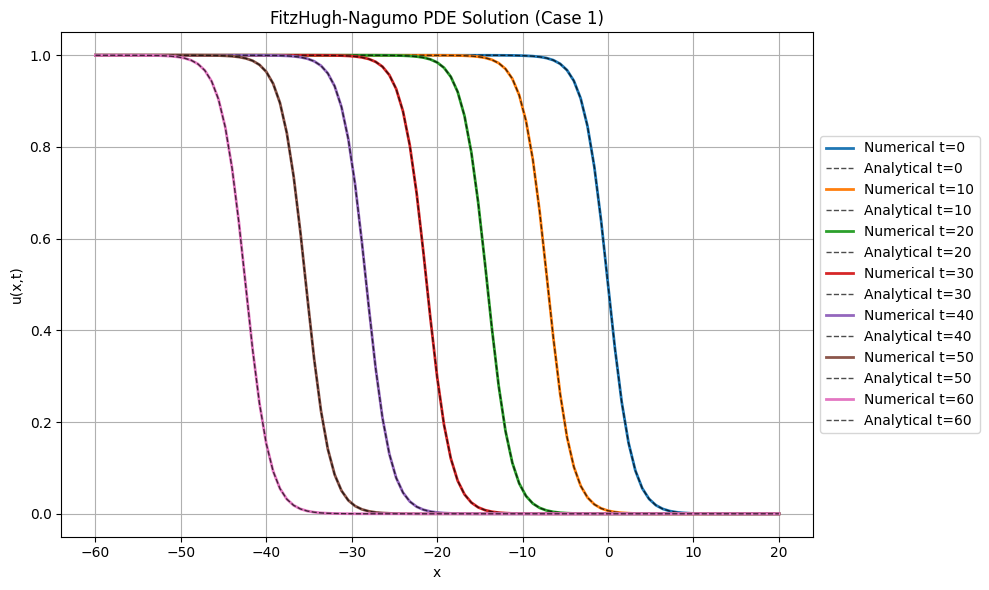

In [1]:
# 🔹 1. Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 🔹 2. Define Parameters and Spatial Grid
a = 1.0
D = 1.0
nx = 101
xl, xu = -60, 20
xg = np.linspace(xl, xu, nx)
dx = xg[1] - xg[0]

# 🔹 3. Time Settings and Boundary Case Selector
t0 = 0
tf = 60
nout = 7
tout = np.linspace(t0, tf, nout)
ncase = 1  # Boundary condition case

# 🔹 4. Analytical Solution and Derivative
def ua_1(x, t):
    return 1 / (1 + np.exp((x / np.sqrt(2 * D)) + (a - 0.5) * t))

def uxa_1(x, t):
    expa = np.exp((x / np.sqrt(2 * D)) + (a - 0.5) * t)
    return -expa / (np.sqrt(2 * D) * (1 + expa)**2)

# 🔹 5. Initial Condition
def initial_condition():
    return ua_1(xg, 0)

# 🔹 6. 4th-order Finite Difference Scheme
def dss004(u, dx):
    uxx = np.zeros_like(u)
    uxx[2:-2] = (-u[:-4] + 16*u[1:-3] - 30*u[2:-2] + 16*u[3:-1] - u[4:]) / (12*dx**2)
    uxx[0] = (2*u[0] - 5*u[1] + 4*u[2] - u[3]) / dx**2
    uxx[1] = (u[0] - 2*u[1] + u[2]) / dx**2
    uxx[-1] = (2*u[-1] - 5*u[-2] + 4*u[-3] - u[-4]) / dx**2
    uxx[-2] = (u[-1] - 2*u[-2] + u[-3]) / dx**2
    return uxx

# 🔹 7. Define the PDE System
def fhn_pde(t, u):
    u = u.copy()
    dudt = np.zeros_like(u)

    # Boundary conditions
    if ncase == 1:
        u[0] = ua_1(xg[0], t)
        u[-1] = ua_1(xg[-1], t)
    elif ncase == 2:
        u[0] = 1.0
        u[-1] = 0.0

    # Compute second spatial derivative
    uxx = dss004(u, dx)

    if ncase == 3:
        uxx[0] = uxa_1(xg[0], t)
        uxx[-1] = uxa_1(xg[-1], t)
    elif ncase == 4:
        uxx[0] = 0
        uxx[-1] = 0

    # Time derivative from FitzHugh–Nagumo
    dudt = D * uxx - u * (1 - u) * (a - u)

    if ncase in [1, 2]:
        dudt[0] = 0
        dudt[-1] = 0

    return dudt

# 🔹 8. Solve the PDE System
u0 = initial_condition()
sol = solve_ivp(fhn_pde, [t0, tf], u0, t_eval=tout, method='BDF', rtol=1e-6, atol=1e-8)

# 🔹 9. Compute Analytical Solution
u_plot = sol.y
ua_plot = np.array([[ua_1(xg[i], t) for t in tout] for i in range(nx)])

# 🔹 10. Print Numerical vs Analytical Results
print("\n t       x        u(x,t)     u_ex(x,t)   u_err(x,t)")
for it, t in enumerate(tout):
    for ix in range(0, nx, 10):
        u_num = u_plot[ix, it]
        u_exact = ua_plot[ix, it]
        u_err = u_num - u_exact
        print(f"{t:5.1f} {xg[ix]:8.2f} {u_num:10.5f} {u_exact:12.5f} {u_err:13.6f}")

# 🔹 11. Plot the Results
plt.figure(figsize=(10, 6))
for it, t in enumerate(tout):
    plt.plot(xg, u_plot[:, it], label=f"Numerical t={t:.0f}", lw=2)
    plt.plot(xg, ua_plot[:, it], 'k--', label=f"Analytical t={t:.0f}", lw=1, alpha=0.7)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title(f'FitzHugh-Nagumo PDE Solution (Case {ncase})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()
